## Libraries

In [2]:
import pandas as pd

AttributeError: module 'numpy' has no attribute '__version__'

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import LSTM, Flatten, Dense, Dropout, SimpleRNN

In [ ]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

## Data Import

In [3]:
file = drive.CreateFile({'id': '1NyFcpT_FJdSrpYIUhrDeggNyI794b8y5'})
file.GetContentFile("prices.npy")
prices = np.load(file.content)
prices.shape

(139680, 7, 5)

In [3]:
prices = np.load("../Databases/prices.npy")
prices.shape

(139680, 7, 5)

## Normalize and Split

In [4]:
changes = np.divide(prices[1:], prices[:-1])
features = np.log(changes)
dollars = np.zeros((features.shape[0], 1, features.shape[2]))
features = np.append(features, dollars, axis=1)
features = features[:,0,0].reshape(len(features), 1, 1)
features.shape

(139679, 1, 1)

In [5]:
split = int(len(features) * 0.8)
train = features[:split]
valid = features[split:]
print(train.shape, valid.shape)

(111743, 1, 1) (27936, 1, 1)


## Batch Generation

In [6]:
granularity = 2    # Every 24 records = 2 hours
numSteps = 100        # 48 timestamps = 16 days

batchSize = 10
skipStep = 1
numEpochs = 20

In [7]:
(len(train) - ((numSteps+1) * granularity)) // skipStep

111541

In [8]:
indeces = np.arange(0, 0 + numSteps*granularity, granularity)
train.reshape(train.shape[0], train.shape[1] * train.shape[2])[indeces].shape

(100, 1)

In [9]:
def createAllBatches(data, numSteps, granularity, batchSize, skipStep):
    data = data.reshape(data.shape[0], data.shape[1] * data.shape[2])
    index = 0
    numBatches = (len(data) - ((numSteps+1) * granularity)) // skipStep
    x = np.empty((numBatches, numSteps, 1))
    y = np.empty((numBatches, 1))
    #for i in range(numBatches):
    i = 0
    while True:
        try:
            if index + numSteps*granularity >= len(data): break
            indeces = np.arange(index, index + numSteps*granularity, granularity)
            x[i] = data[indeces]
            y[i] = data[index + numSteps*granularity]
            index += skipStep
            i +=1
        except IndexError as e:
            print(e)
            print(len(data), indeces)
            break
    return x, y

In [10]:
trainX, trainY = createAllBatches(train, numSteps, granularity, batchSize, skipStep)

index 111541 is out of bounds for axis 0 with size 111541
111743 [111541 111543 111545 111547 111549 111551 111553 111555 111557 111559
 111561 111563 111565 111567 111569 111571 111573 111575 111577 111579
 111581 111583 111585 111587 111589 111591 111593 111595 111597 111599
 111601 111603 111605 111607 111609 111611 111613 111615 111617 111619
 111621 111623 111625 111627 111629 111631 111633 111635 111637 111639
 111641 111643 111645 111647 111649 111651 111653 111655 111657 111659
 111661 111663 111665 111667 111669 111671 111673 111675 111677 111679
 111681 111683 111685 111687 111689 111691 111693 111695 111697 111699
 111701 111703 111705 111707 111709 111711 111713 111715 111717 111719
 111721 111723 111725 111727 111729 111731 111733 111735 111737 111739]


In [57]:
trainY.shape

(111642, 1)

In [0]:
class BatchGenerator(object):
    """ Input: one three-dimensional tensor of shape (numDates, numCoins, numFeatures)"""
    """ Output: two thee-dimensional tensors of shape (numBatches, numSteps, numCoins*numFeatures)"""

    def __init__(self, data, numSteps, granularity, batchSize, skipStep):   
        self.data = data.reshape(data.shape[0], data.shape[1] * data.shape[2])
        self.numSteps = numSteps
        self.granularity = granularity
        
        self.batchSize = batchSize
        self.skipStep = skipStep
        self.index = 0

    def generate(self):
        x = np.zeros((self.batchSize, self.numSteps, 1))
        y = np.zeros((self.batchSize, 1))
        while True:
            for i in range(self.batchSize):
                if self.index + self.numSteps * self.granularity >= len(self.data): self.index = 0
                indeces = np.sort(np.arange(self.index, self.index + self.numSteps*self.granularity, self.granularity))
                x[i] = self.data[indeces]
                y[i] = self.data[self.index + self.numSteps*self.granularity, 0]
                self.index += self.skipStep
            yield x, y

In [0]:
trainGenerator = BatchGenerator(train, numSteps, granularity, batchSize, skipStep)
validGenerator = BatchGenerator(valid, numSteps, granularity, batchSize, skipStep)

## Model

In [68]:
model = Sequential()
model.add(SimpleRNN(128, input_shape=(numSteps, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse', metrics=['mse'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_1 (SimpleRNN)     (None, 128)               16640     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 129       
Total params: 16,769
Trainable params: 16,769
Non-trainable params: 0
_________________________________________________________________


In [69]:
history = model.fit_generator(trainGenerator.generate(), len(train)//(batchSize*numSteps), numEpochs, 
                              validation_data=validGenerator.generate(), validation_steps=len(valid)//(batchSize*numSteps))

Epoch 1/20
931/931 [==============================] - 12s 13ms/step - loss: 1.5242e-05 - mean_squared_error: 1.5242e-05 - val_loss: 1.5152e-05 - val_mean_squared_error: 1.5152e-05
Epoch 2/20
931/931 [==============================] - 11s 12ms/step - loss: 6.4229e-06 - mean_squared_error: 6.4229e-06 - val_loss: 5.9838e-05 - val_mean_squared_error: 5.9838e-05
Epoch 3/20
236/931 [======>.......................] - ETA: 7s - loss: 2.4194e-05 - mean_squared_error: 2.4194e-05931/931 [==============================] - 11s 12ms/step - loss: 1.5762e-05 - mean_squared_error: 1.5762e-05 - val_loss: 1.2770e-05 - val_mean_squared_error: 1.2770e-05
Epoch 4/20
931/931 [==============================] - 11s 12ms/step - loss: 5.2421e-06 - mean_squared_error: 5.2421e-06 - val_loss: 1.1626e-05 - val_mean_squared_error: 1.1626e-05
Epoch 5/20
345/931 [==========>...................] - ETA: 6s - loss: 9.1507e-06 - mean_squared_error: 9.1507e-06931/931 [==============================] - 11s 12ms/step - loss: 

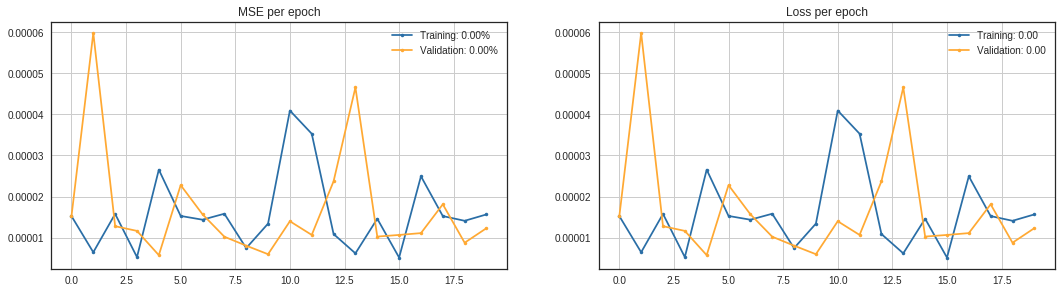

In [70]:
plt.style.use('seaborn-white')

fig = plt.figure(figsize=(18, 10)); ax1 = fig.add_subplot(221); ax2 = fig.add_subplot(222)
tm, tl = history.history['mean_squared_error'], history.history['loss']
vm, vl = history.history['val_mean_squared_error'], history.history['val_loss']

ax1.plot(np.arange(numEpochs), tm,".-", color='#2A6EA6', label="Training: {0:.2f}%".format(tm[-1]))
ax1.plot(np.arange(numEpochs), vm,".-", color='#FFA933', label="Validation: {0:.2f}%".format(vm[-1]))
ax1.grid(True); ax1.legend(); ax1.set_title("MSE per epoch")

ax2.plot(np.arange(numEpochs), tl, ".-", color='#2A6EA6', label="Training: {0:.2f}".format(tl[-1]))
ax2.plot(np.arange(numEpochs), vl,".-", color='#FFA933', label="Validation: {0:.2f}".format(vl[-1]))
ax2.grid(True); ax2.legend(); ax2.set_title("Loss per epoch")
plt.show()

In [75]:
predictions = model.predict_generator(validGenerator.generate(), steps=2)
predictions.shape

(20, 1)

In [76]:
predictions

array([[-0.00051124],
       [-0.0002273 ],
       [-0.00034614],
       [-0.00032173],
       [-0.00026746],
       [-0.00057683],
       [-0.00030578],
       [-0.00032185],
       [-0.00047351],
       [-0.00018348],
       [-0.00051124],
       [-0.0002273 ],
       [-0.00034614],
       [-0.00032173],
       [-0.00026746],
       [-0.00057683],
       [-0.00030578],
       [-0.00032185],
       [-0.00047351],
       [-0.00018348]], dtype=float32)

In [0]:
#data = np.empty((len(valid), numSteps, 1))
for i, (x, y) in enumerate(validGenerator.generate()): 
    x = x
    y = y
    if i == 0: break


In [61]:
x[0]

array([[-0.00083137],
       [-0.00487266],
       [-0.00148367],
       [ 0.00037055],
       [ 0.00148638],
       [-0.0022304 ],
       [ 0.00082714],
       [-0.01260258],
       [-0.00320586],
       [ 0.00782303],
       [-0.01313766],
       [ 0.00581764]])

In [65]:
y[0]

array([-0.01183901])

In [54]:
valid[:12,0,0]

[-0.00083137 -0.00487266 -0.00148367  0.00037055  0.00148638 -0.0022304
  0.00082714 -0.01260258 -0.00320586  0.00782303 -0.01313766  0.00581764]
